In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train
VOCAB_SIZE = 1000
EMBEDDING_SIZE = 6
BATCH_SIZE = 8192
EPOCH = 10
WINDOW_SIZE = 1
# display number
DISNUM = 50

# name
name = 'fnn-' + 'epo' + str(EPOCH) + 'ebd' + str(EMBEDDING_SIZE) + 'vcb' + str(VOCAB_SIZE) + 'win' + str(WINDOW_SIZE)

In [9]:
class FNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(FNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        out = F.relu(self.fc1(embedding))
        out = self.fc2(out)
        return F.log_softmax(out, dim=-1)

In [10]:
# read corpus from file
corpus = []
with open('ChineseCorpus199801-cleaned.txt', 'r', encoding='gbk') as f:
    for line in f:
        corpus.append(line.strip().split(' '))
# build word_to_ix
word_to_ix = {}
for sentence in corpus:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_to_ix = {k: v if v < VOCAB_SIZE else VOCAB_SIZE for k, v in word_to_ix.items()}
word_to_ix['<UNK>'] = VOCAB_SIZE

In [11]:
inputs = []
targets = []
for sentence in corpus:
    for i in range(len(sentence)):
        for j in range(-WINDOW_SIZE, WINDOW_SIZE+1):
            if j != 0 and i+j >= 0 and i+j < len(sentence):
                inputs.append(word_to_ix[sentence[i]])
                targets.append(word_to_ix[sentence[i+j]])

# convert to tensor
inputs = torch.tensor(inputs, dtype=torch.long).to(device)
targets = torch.tensor(targets, dtype=torch.long).to(device)

In [12]:
# train model, inputs are single words and targets are their contexts
model = FNN(VOCAB_SIZE+1, EMBEDDING_SIZE, 128)
model.to('cuda:0')
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(EPOCH):
    total_loss = 0
    for i in tqdm.tqdm(range(0, len(corpus), BATCH_SIZE)):
        input = inputs[i:i+BATCH_SIZE]
        target = targets[i:i+BATCH_SIZE]
        model.zero_grad()
        log_probs = model(input)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('Epoch:', epoch, 'Loss:', total_loss)
word_vectors = np.array(model.embedding.weight.data.cpu())

100%|██████████| 3/3 [00:00<00:00, 12.30it/s]


Epoch: 0 Loss: 20.444818019866943


100%|██████████| 3/3 [00:00<00:00, 31.91it/s]


Epoch: 1 Loss: 20.067595958709717


100%|██████████| 3/3 [00:00<00:00, 149.97it/s]


Epoch: 2 Loss: 19.702139377593994


100%|██████████| 3/3 [00:00<00:00, 149.98it/s]


Epoch: 3 Loss: 19.342132568359375


100%|██████████| 3/3 [00:00<00:00, 142.78it/s]


Epoch: 4 Loss: 18.986802577972412


100%|██████████| 3/3 [00:00<00:00, 142.79it/s]


Epoch: 5 Loss: 18.63544225692749


100%|██████████| 3/3 [00:00<00:00, 142.84it/s]


Epoch: 6 Loss: 18.287381649017334


100%|██████████| 3/3 [00:00<00:00, 142.88it/s]


Epoch: 7 Loss: 17.942216396331787


100%|██████████| 3/3 [00:00<00:00, 142.88it/s]


Epoch: 8 Loss: 17.59945011138916


100%|██████████| 3/3 [00:00<00:00, 166.63it/s]

Epoch: 9 Loss: 17.258615970611572


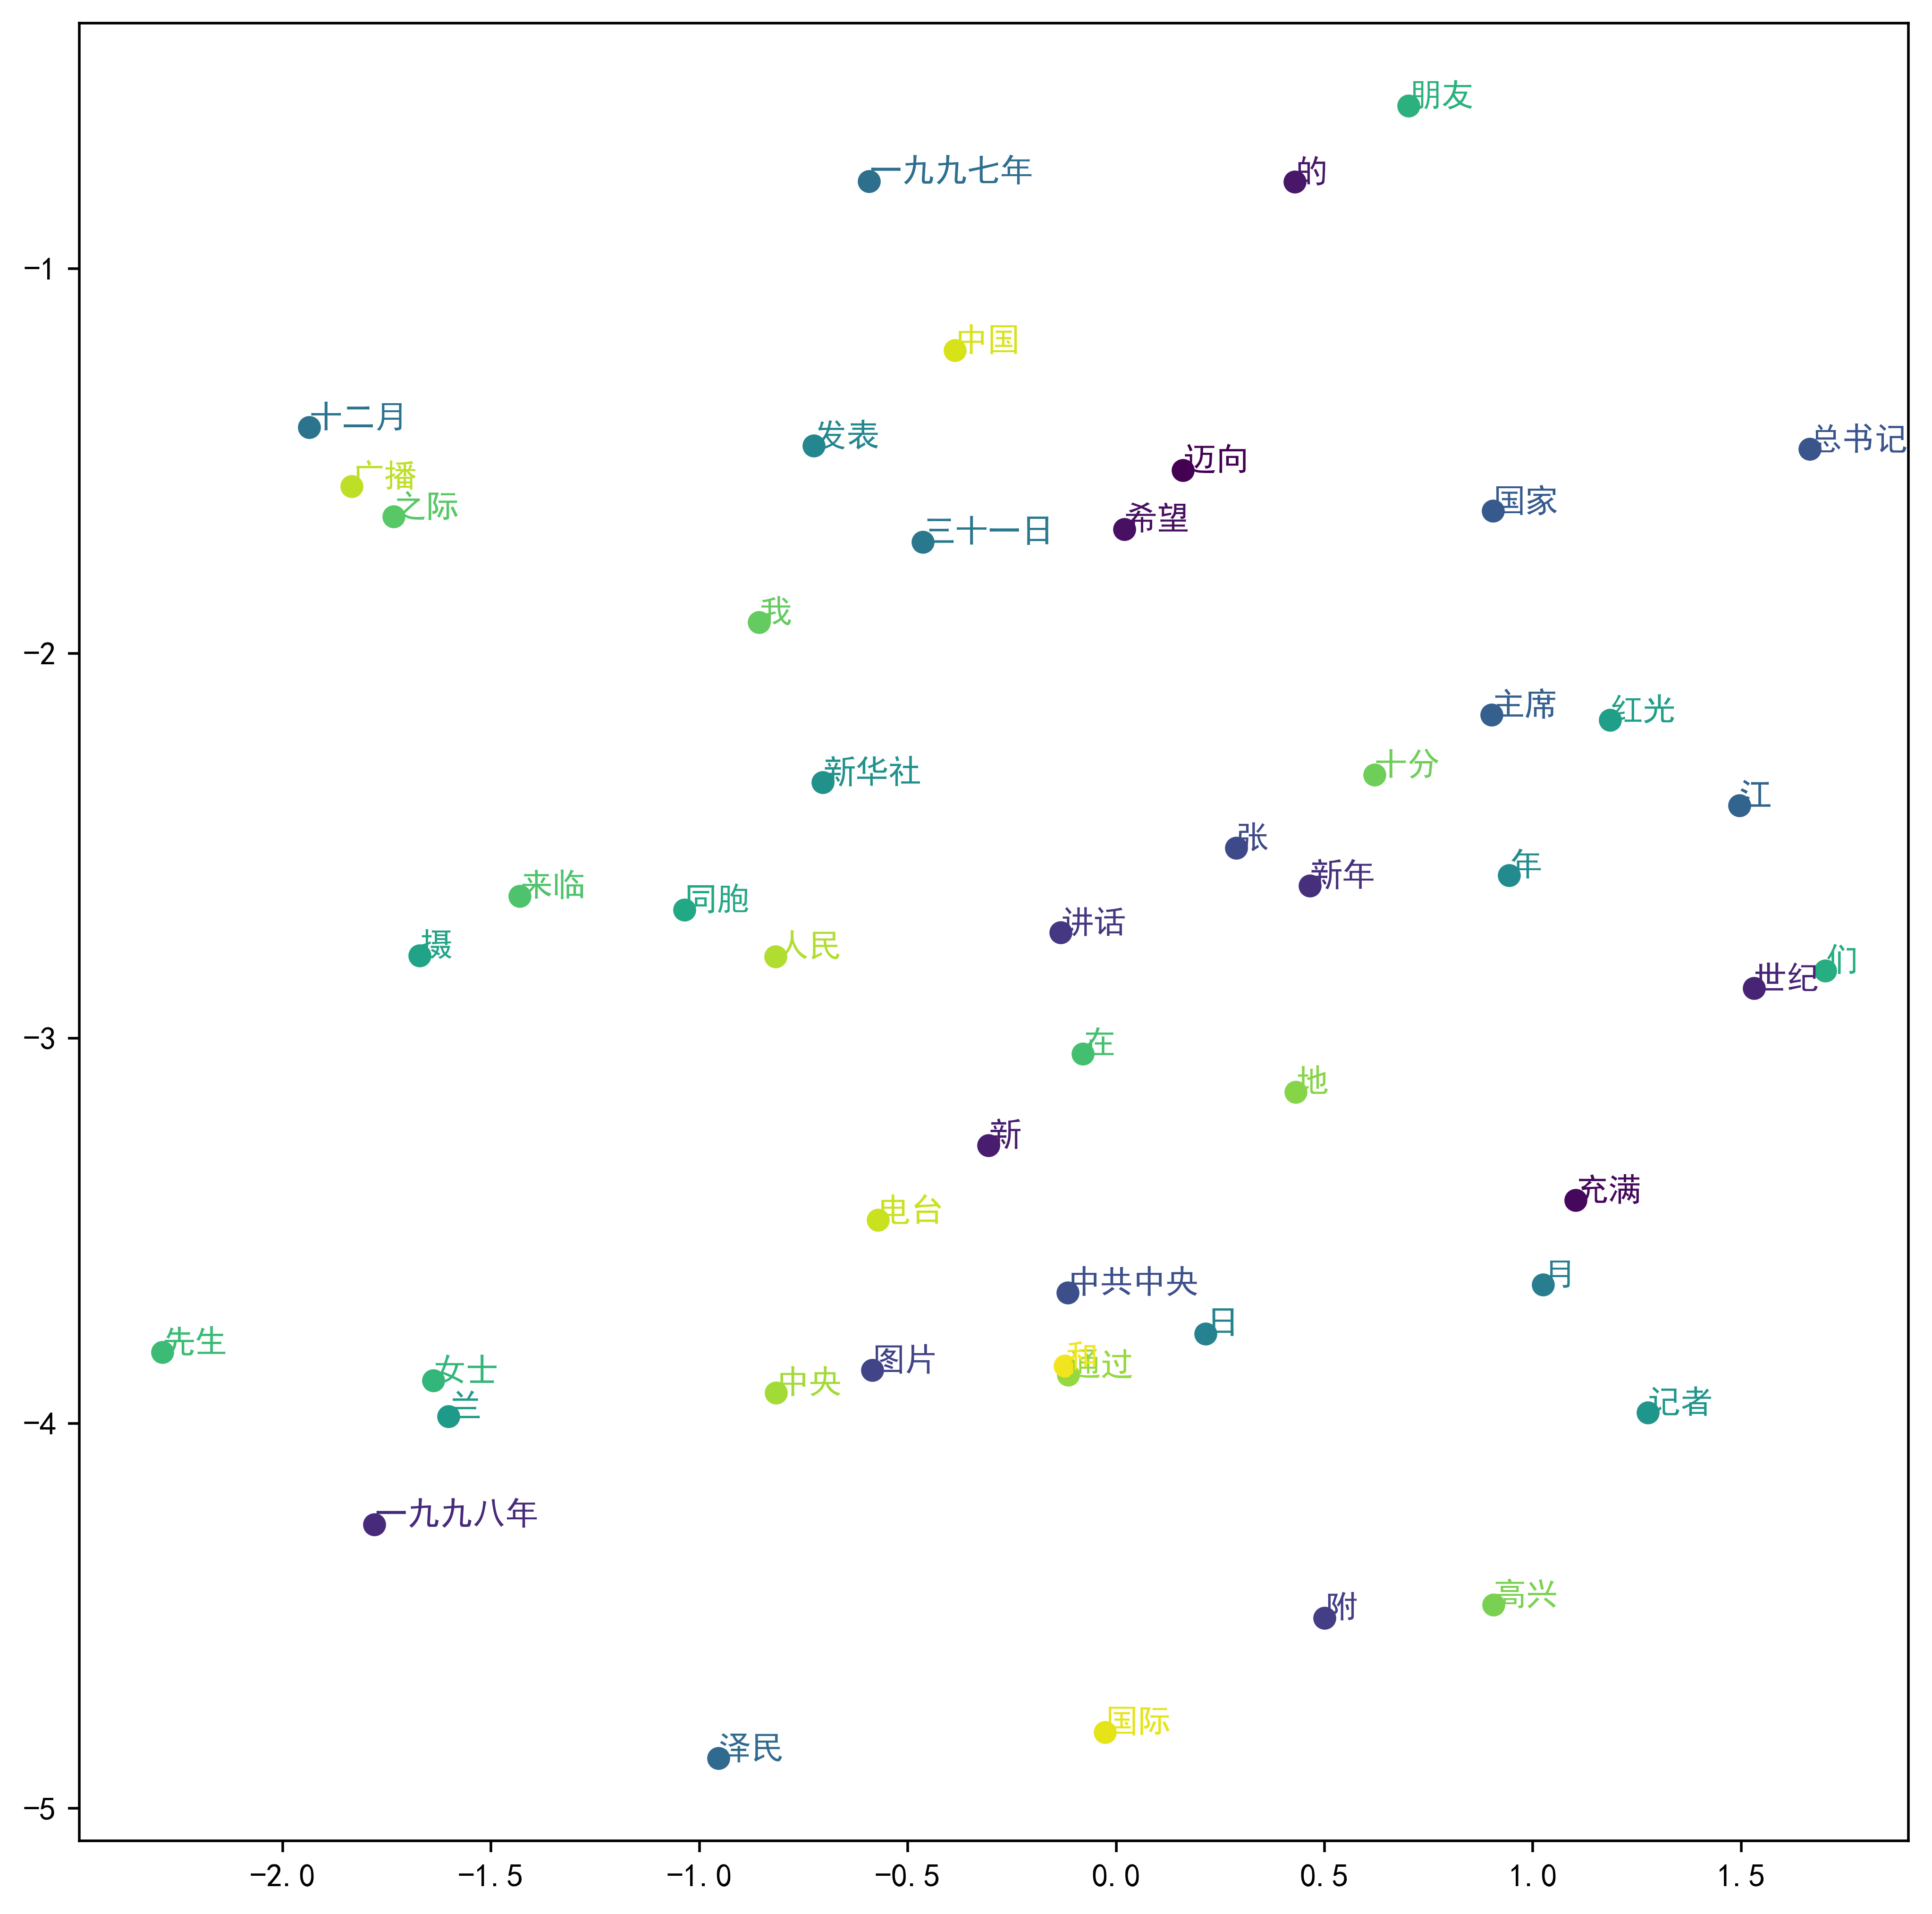

In [13]:
# tsne
tsne = TSNE(n_components=2, random_state=0)
word_vectors_tsne = tsne.fit_transform(word_vectors[:DISNUM])

# plot
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

cmap = plt.get_cmap('viridis')
# cmap = plt.get_cmap('tab10')
for i, word in enumerate(word_to_ix):
    if i == DISNUM:
        break
    color = cmap(i/DISNUM)
    ax.scatter(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], color=color)
    ax.annotate(word, xy=(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), color=color)
plt.savefig(name + '.png')
torch.save(model.state_dict(), name + '.pth')

In [14]:
import pandas as pd
import os
word_list = list(word_to_ix.keys())[::10][:20]
# get similar words using cosine similarity
def get_similar_words(word, n=10):
    if word not in word_to_ix:
        print('Word not in vocabulary')
        return
    word_vector = word_vectors[word_to_ix[word]]
    similarities = np.dot(word_vectors, word_vector) / (np.linalg.norm(word_vectors, axis=1) * np.linalg.norm(word_vector))
    sorted_indices = np.argsort(similarities)[::-1][1:n+1]
    similar_words = []
    similarity_scores = []
    for i in sorted_indices:
        similar_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(i)]
        similarity = similarities[i]
        similar_words.append(similar_word)
        similarity_scores.append(similarity)
    df = pd.DataFrame({'Similar Words': similar_words, 'Similarity Scores': similarity_scores})
    if not os.path.exists(name):
        os.makedirs(name)
    df.to_excel(f'{name}/{name}_{word}.xlsx', index=False)
for word in word_list:
    get_similar_words(word)